In [1]:
import tensorflow as tf
import numpy as np
import scipy

In [2]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 14})

In [3]:
import sys
sys.path.insert(0,'..')

In [4]:
from energy_models.particle_dimer import ParticleDimer
from boltzmann_generator import BoltzmannGenerator

In [5]:
from analysis import free_energy_bootstrap, mean_finite, std_finite

## Load training dataset
Run notebook `particle_dimer_produce_training_dataset` to produce training and testing datasets together with umbrella sampling data. 

In [6]:
# Load MC trajectory data
trajdict = np.load('../resources/bistable_dimer_training_data.npz', allow_pickle=True)
# Loading a dictionary from np.ndarray is a little bit complicated
params = dict(enumerate(trajdict['params'].flatten()))[0]
traj_closed_train = trajdict['traj_closed_train_hungarian']
traj_open_train = trajdict['traj_open_train_hungarian']
traj_closed_test = trajdict['traj_closed_test_hungarian']
traj_open_test = trajdict['traj_open_test_hungarian']

Construct training and validation datasets by merging trajectories from opened and closed dimer states.

In [7]:
training_dataset = np.vstack([traj_closed_train, traj_open_train])
validation_dataset = np.vstack([traj_closed_test, traj_open_test])

In [8]:
print("Size of training dataset:", training_dataset.shape[0])
print("Size of validation dataset:", validation_dataset.shape[0])

Size of training dataset: 99800
Size of validation dataset: 99800


## Energy model

In [9]:
print(params)
model = ParticleDimer(params=params)

{'n_solvent': 36, 'eps': 1.0, 'rm': 1.1, 'dimer_slope': 2.0, 'dimer_a': 25.0, 'dimer_b': 10.0, 'dimer_dmid': 1.5, 'dimer_k': 20.0, 'box_halfsize': 3.0, 'box_k': 100.0, 'grid_k': 0.0}


Text(0, 0.5, 'Energy / $kT$')

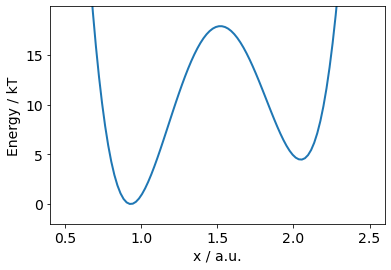

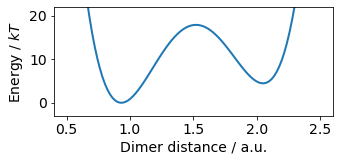

In [10]:
xx, xE = model.plot_dimer_energy();
plt.figure(figsize=(5, 2))
plt.plot(xx, xE, linewidth=2)
plt.ylim(-3, 22)
plt.xlabel('Dimer distance / a.u.')
plt.ylabel('Energy / $kT$')

Boltzmann Generator
-------

Construct Boltzmann generator

In [11]:
bg = BoltzmannGenerator(
    'R' * 8,
    model,
    nl_layers=4,
    nl_hidden=200
)

Layers of invertible NN: <RRRRRRRR>
< 76 0 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
> 38 38 0


In [12]:
rc_loss_params = {
    'rc_function': model.dimer_distance_tf, 
    'rc_min': 0.5, 
    'rc_max': 2.5
}

Functions to set "low energy" limit in both $x$ an $z$ space

In [13]:
def energy_cut_z(ndim, n_std=3):
    z = np.random.randn(10000, ndim)
    z_ener = 0.5 * np.sum(z**2, axis=1)
    std = np.sqrt(np.mean((z_ener - z_ener.mean())**2))
    # mean energies of samples from z + n_std times their standard deviation
    return z_ener.mean() + n_std*std

def low_energy_fraction(energies, E_max):
    low_energy_count = [np.count_nonzero(E<E_max) for E in energies]
    total_size = [E.shape[0] for E in energies]
    low_energy_fraction = np.array(low_energy_count) / total_size
    return low_energy_fraction

In [14]:
save_dir_and_prefix = '../resources/bg_particle_dimer'
z_low_limit = energy_cut_z(model.dim, n_std=3)
# RC entropy is calculated from histogram with 11 bins, see losses.py
max_rc_entropy = np.log(11)  


def plot_convergence(loss_vals, x_energies, z_energies, rc_loss_weight):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    for loss_name in ["loss", "val_loss"]:
        axes[0].plot(loss_vals[loss_name], label=loss_name)
    axes[0].set_xlabel("Iteration")
    axes[0].set_ylabel("Loss")
    axes[0].legend(loc='upper right')
        
    line1, = axes[1].plot(low_energy_fraction(z_energies, E_max=z_low_limit)*100, label="$z$")
    line2, = axes[1].plot(low_energy_fraction(x_energies, E_max=80)*100, label="$x$")
    axes[1].set_xlabel("Iteration")
    axes[1].set_ylabel("% of samples with $E < E_{low}$")
    axes[1].set_ylim(-5, 105)
    
    rc_axis = axes[1].twinx()
    rc_loss = loss_vals.get('RC_loss', np.array([]))
    line3, = rc_axis.plot(-rc_loss/rc_loss_weight/max_rc_entropy, color='green', label="$H_{RC}$")
    rc_axis.yaxis.tick_right()
    rc_axis.set_ylim(-0.05,1.05)
    rc_axis.yaxis.set_label_position('right')
    rc_axis.set_ylabel("RC entropy / max possible")
    rc_axis.legend(loc='lower right', handles=[line1, line2, line3])

    plt.subplots_adjust(wspace=0.3)
    plt.show()

    
# Training script
def train_bg(bg, training_schedule, save_from_stage=3):
    for i, args in enumerate(training_schedule):
        input("Should training continue? (press Enter)")
        current_loss_vals, x_energies, z_energies = bg.train(
            training_dataset,
            x_val = validation_dataset,
            weight_ML = args[0],
            weight_KL = args[1],
            weight_RCEnt = args[2],
            iterations = args[3],
            batch_size = args[4],
            lr = args[5],
            high_energy = args[6],
            print_total_loss_only = True,
            print_training_info_interval = 20,
            return_validation_energies = True,
            **rc_loss_params
        )
        if i + 1 >= save_from_stage:
            bg.save(save_dir_and_prefix + '/bg_model')
        
        plot_convergence(current_loss_vals, x_energies, z_energies, rc_loss_weight=args[2])

        

In [15]:
training_schedule = [
#    w_ML, w_KL, w_RC, iter, b_size,   lr, E_high  
    [   1,    0,    0,   20,    256, 1e-3,   1e4],
    [ 100,    1,    1,  200,   8000, 1e-4,   1e4],
    [ 100,    1,    5,  300,   8000, 1e-4,   1e4],
    [ 100,    1,   10,  300,   8000, 1e-4,   1e4],
    [  20,    1,   10, 1000,   8000, 1e-4,   2e3],
    [ 0.1,    1,   10, 2000,   8000, 1e-4,   1e3],
]

## Training

In [16]:
# Load BG if it's already trained.
# bg.load(save_dir_and_prefix, load_latest_checkpoint=True)

Should training continue? (press Enter)
Iteration 0/20: loss: 233.45 val_loss: 55.41 


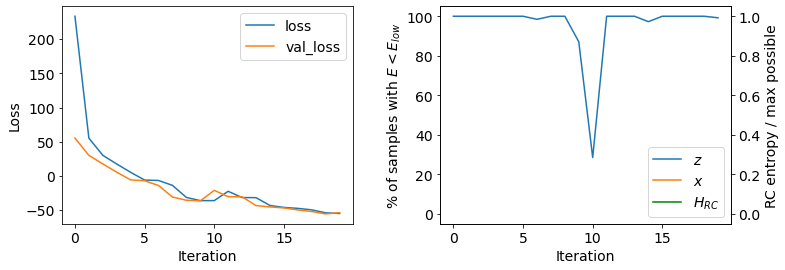

Should training continue? (press Enter)
Iteration 0/200: loss: 4654.27 val_loss: 4321.99 
Iteration 20/200: loss: -3789.21 val_loss: -3957.05 
Iteration 40/200: loss: -5976.72 val_loss: -5968.91 
Iteration 60/200: loss: -6729.32 val_loss: -6752.52 
Iteration 80/200: loss: -7240.57 val_loss: -7255.74 
Iteration 100/200: loss: -7624.58 val_loss: -7606.40 
Iteration 120/200: loss: -7919.71 val_loss: -7935.75 
Iteration 140/200: loss: -8146.54 val_loss: -8179.87 
Iteration 160/200: loss: -8405.77 val_loss: -8387.23 
Iteration 180/200: loss: -8566.59 val_loss: -8558.73 


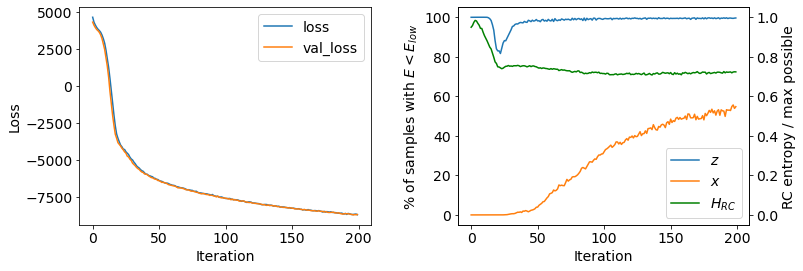

Should training continue? (press Enter)
Iteration 0/300: loss: -8726.81 val_loss: -8731.61 
Iteration 20/300: loss: -8865.64 val_loss: -8876.08 
Iteration 40/300: loss: -8942.93 val_loss: -8965.02 
Iteration 60/300: loss: -9064.40 val_loss: -9114.19 
Iteration 80/300: loss: -9197.44 val_loss: -9197.18 
Iteration 100/300: loss: -9246.96 val_loss: -9292.86 
Iteration 120/300: loss: -9340.31 val_loss: -9339.19 
Iteration 140/300: loss: -9391.29 val_loss: -9391.19 
Iteration 160/300: loss: -9430.90 val_loss: -9479.92 
Iteration 180/300: loss: -9516.63 val_loss: -9497.57 
Iteration 200/300: loss: -9595.30 val_loss: -9599.98 
Iteration 220/300: loss: -9642.27 val_loss: -9621.34 
Iteration 240/300: loss: -9652.42 val_loss: -9602.50 
Iteration 260/300: loss: -9716.45 val_loss: -9732.12 
Iteration 280/300: loss: -9750.54 val_loss: -9707.28 


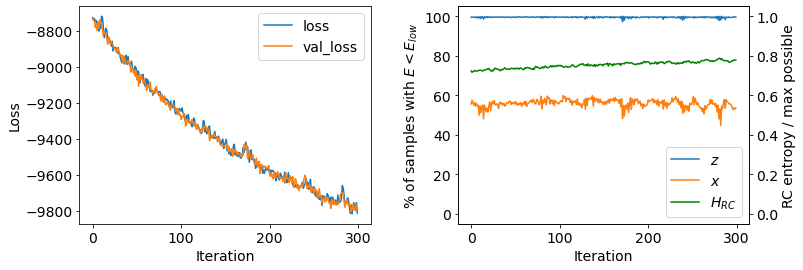

Should training continue? (press Enter)
Iteration 0/300: loss: -9824.66 val_loss: -9811.64 
Iteration 20/300: loss: -9820.72 val_loss: -9849.45 
Iteration 40/300: loss: -9879.84 val_loss: -9868.65 
Iteration 60/300: loss: -9914.86 val_loss: -9873.46 
Iteration 80/300: loss: -9972.87 val_loss: -9944.28 
Iteration 100/300: loss: -10023.10 val_loss: -9982.99 
Iteration 120/300: loss: -10022.85 val_loss: -10005.95 
Iteration 140/300: loss: -10025.91 val_loss: -10031.32 
Iteration 160/300: loss: -10047.92 val_loss: -10090.59 
Iteration 180/300: loss: -10098.39 val_loss: -10106.66 
Iteration 200/300: loss: -10117.03 val_loss: -10150.90 
Iteration 220/300: loss: -10140.32 val_loss: -10128.60 
Iteration 240/300: loss: -10141.21 val_loss: -10132.37 
Iteration 260/300: loss: -10190.16 val_loss: -10205.30 
Iteration 280/300: loss: -10225.75 val_loss: -10214.52 


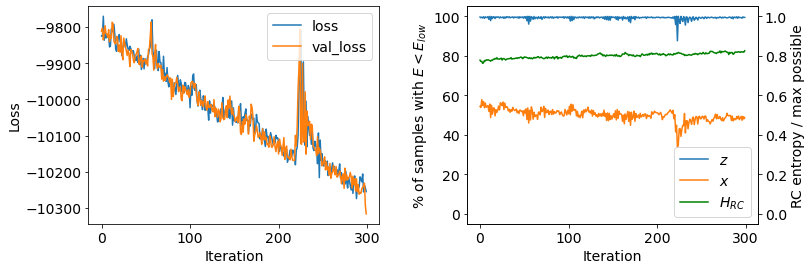

Should training continue? (press Enter)
Iteration 0/1000: loss: -1810.13 val_loss: -1807.97 
Iteration 20/1000: loss: -1834.58 val_loss: -1830.21 
Iteration 40/1000: loss: -1840.62 val_loss: -1827.57 
Iteration 60/1000: loss: -1827.71 val_loss: -1839.88 
Iteration 80/1000: loss: -1842.70 val_loss: -1843.12 
Iteration 100/1000: loss: -1843.50 val_loss: -1841.66 
Iteration 120/1000: loss: -1840.03 val_loss: -1848.04 
Iteration 140/1000: loss: -1846.27 val_loss: -1845.81 
Iteration 160/1000: loss: -1843.73 val_loss: -1840.09 
Iteration 180/1000: loss: -1845.96 val_loss: -1843.58 
Iteration 200/1000: loss: -1855.10 val_loss: -1847.04 
Iteration 220/1000: loss: -1851.59 val_loss: -1851.63 
Iteration 240/1000: loss: -1855.12 val_loss: -1848.44 
Iteration 260/1000: loss: -1852.85 val_loss: -1843.45 
Iteration 280/1000: loss: -1850.64 val_loss: -1852.30 
Iteration 300/1000: loss: -1854.12 val_loss: -1856.08 
Iteration 320/1000: loss: -1855.40 val_loss: -1861.18 
Iteration 340/1000: loss: -1851

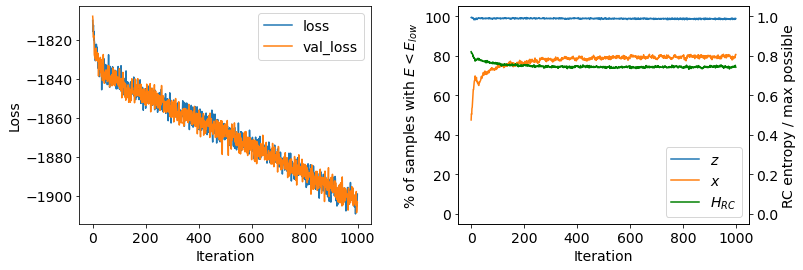

Should training continue? (press Enter)
Iteration 0/2000: loss: 248.07 val_loss: 245.78 
Iteration 20/2000: loss: 234.51 val_loss: 234.02 
Iteration 40/2000: loss: 232.84 val_loss: 232.72 
Iteration 60/2000: loss: 232.03 val_loss: 231.82 
Iteration 80/2000: loss: 231.07 val_loss: 231.51 
Iteration 100/2000: loss: 230.63 val_loss: 230.78 
Iteration 120/2000: loss: 230.48 val_loss: 230.42 
Iteration 140/2000: loss: 230.23 val_loss: 230.16 
Iteration 160/2000: loss: 229.84 val_loss: 230.15 
Iteration 180/2000: loss: 229.35 val_loss: 229.68 
Iteration 200/2000: loss: 229.32 val_loss: 229.57 
Iteration 220/2000: loss: 229.49 val_loss: 229.23 
Iteration 240/2000: loss: 228.85 val_loss: 229.30 
Iteration 260/2000: loss: 228.61 val_loss: 228.97 
Iteration 280/2000: loss: 228.79 val_loss: 228.81 
Iteration 300/2000: loss: 228.68 val_loss: 228.52 
Iteration 320/2000: loss: 228.39 val_loss: 228.59 
Iteration 340/2000: loss: 228.61 val_loss: 228.35 
Iteration 360/2000: loss: 228.04 val_loss: 228.4

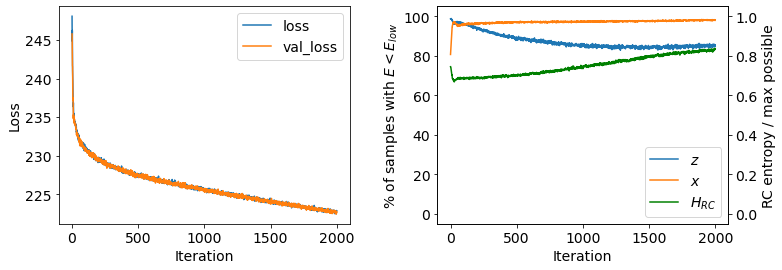

In [17]:
train_bg(bg, training_schedule)

In [18]:
# Save the BG
# bg.save(save_dir_and_prefix + '/bg_model')

## Evaluate BG

### Check sampling of configurations in $x$

In [19]:
_, sample_x, _, energies_x, _ = bg.sample(n_sample=100000)

Check that random configuration looks normal.

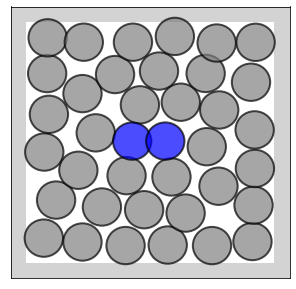

In [20]:
model.draw_config(sample_x[np.random.randint(0, 10000)])

Text(0.5, 0, 'Dimer distance')

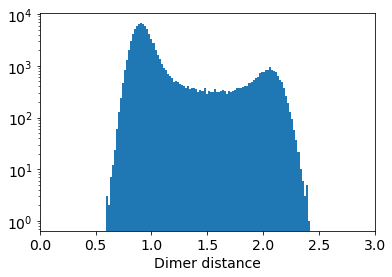

In [21]:
# Check sampling along RC
sample_d = model.dimer_distance(sample_x)
plt.hist(sample_d[sample_d < 3], 100, log=True)
plt.xlim(0, 3)
plt.xlabel("Dimer distance")

Text(0, 0.5, 'Probability')

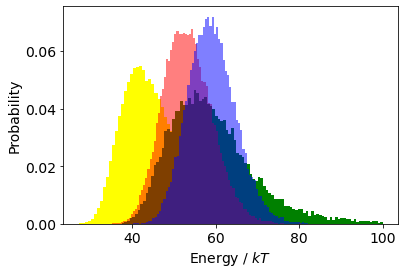

In [22]:
# Compare sampling of system energies by BG with the training dataset
# Closed states by BG
plt.hist(energies_x[np.bitwise_and(energies_x<100, sample_d<1.5)], 100, color='yellow', density=True)
# Opened states by BG
plt.hist(energies_x[np.bitwise_and(energies_x<100, sample_d>1.5)], 100, color='green', density=True)
# Closed states in training dataset
plt.hist(model.energy(traj_closed_train), 100, color='red', alpha=0.5, density=True)
# Opened states in training dataset
plt.hist(model.energy(traj_open_train), 100, color='blue', alpha=0.5, density=True)
plt.xlabel("Energy / $kT$")
plt.ylabel("Probability")

Text(0.5, 0, 'Energy / $kT$')

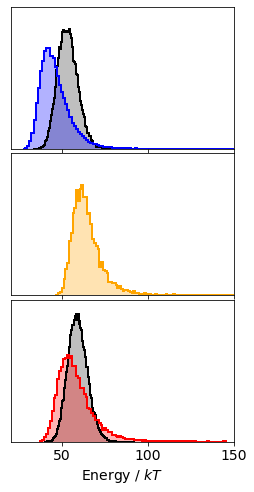

In [23]:
traj_closed_train_energies = model.energy(traj_closed_train)
traj_open_train_energies = model.energy(traj_open_train)

I_closed = np.where(model.dimer_distance(sample_x) < 1.3)[0]
energies_x_closed = energies_x[I_closed][energies_x[I_closed]<150]
I_ts = np.where(np.logical_and(model.dimer_distance(sample_x) > 1.3, model.dimer_distance(sample_x) < 1.7))[0]
energies_x_ts = energies_x[I_ts][energies_x[I_ts]<150]
I_open = np.where(model.dimer_distance(sample_x) > 1.7)[0]
energies_x_open = energies_x[I_open][energies_x[I_open]<150]

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(4, 8), sharex=True)
plt.subplots_adjust(wspace=0.03, hspace=0.03)

axes[0].hist(traj_closed_train_energies, 100, color='black', histtype='step', linewidth=2, density=True);
axes[0].hist(traj_closed_train_energies, 100, color='grey', alpha=0.5, density=True);
axes[0].hist(energies_x_closed, 100, color='blue', histtype='step', linewidth=2, density=True);
axes[0].hist(energies_x_closed, 100, color='blue', alpha=0.3, density=True);
axes[0].set_yticks([])
axes[0].set_ylim(0, 0.08)
axes[0].set_xlim(20, 150)

axes[1].hist(energies_x_ts, 100, color='orange', histtype='step', linewidth=2, density=True);
axes[1].hist(energies_x_ts, 100, color='orange', alpha=0.3, density=True);
axes[1].set_yticks([])
axes[1].set_ylim(0, 0.08)
axes[1].set_xlim(20, 150)

axes[2].hist(traj_open_train_energies, 100, color='black', histtype='step', linewidth=2, density=True);
axes[2].hist(traj_open_train_energies, 100, color='grey', alpha=0.5, density=True);
axes[2].hist(energies_x_open, 100, color='red', histtype='step', linewidth=2, density=True);
axes[2].hist(energies_x_open, 100, color='red', alpha=0.3, density=True);
axes[2].set_yticks([])
axes[2].set_xlim(20, 150)
axes[2].set_ylim(0, 0.08)
axes[2].set_xlabel('Energy / $kT$')

### Latent interpolation

In [24]:
def latent_interpolation(bg, x1, x2, n_step=1000, through_origin=False):
    lambdas = np.array([np.linspace(0, 1, num=n_step)]).T
    x1 = np.array([x1])
    x2 = np.array([x2])
    z1 = bg.transform_xz(x1)
    z2 = bg.transform_xz(x2)
    if through_origin:
        z_path_1 = z1 * (1-lambdas[::2])
        z_path_2 = z2 * (lambdas[::2]) 
        z_path = np.vstack([zpath1, zpath2])
    else:
        z_path = z1 + lambdas*(z2 - z1)
    x_path = bg.transform_zx(z_path)
    return x_path

In [25]:
# Try to find minimum energy path
E_min = 1e9
best_path = None
N = 90

i_min = None
j_min = None
for i in range(N):
    if i % 10 == 0:
        print("i =", i)
    for j in range(N):
        path = latent_interpolation(bg, traj_closed_train[i*100], traj_open_train[j*100], n_step=9)
        E = model.energy(path).max()
        if E < E_min:
            E_min = E
            best_path = path
            i_min = i
            j_min = j
            
print("E_min:", E_min)

i = 0
i = 10
i = 20
i = 30
i = 40
i = 50
i = 60
i = 70
i = 80
E_min: 80.94055938720703


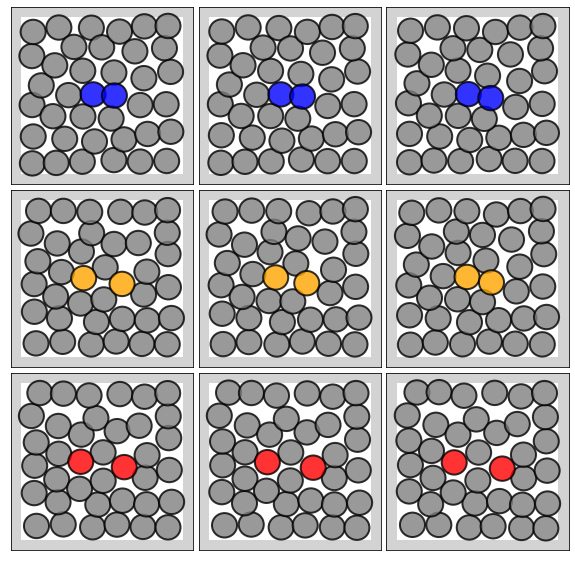

In [26]:
# Show the best path
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
model.draw_config(best_path[0], axis=axes[0, 0], dimer_color='blue', alpha=0.8)
model.draw_config(best_path[1], axis=axes[0, 1], dimer_color='blue', alpha=0.8)
model.draw_config(best_path[2], axis=axes[0, 2], dimer_color='blue', alpha=0.8)

model.draw_config(best_path[3], axis=axes[1, 2], dimer_color='orange', alpha=0.8)
model.draw_config(best_path[4], axis=axes[1, 1], dimer_color='orange', alpha=0.8)
model.draw_config(best_path[5], axis=axes[1, 0], dimer_color='orange', alpha=0.8)

model.draw_config(best_path[6], axis=axes[2, 0], dimer_color='red', alpha=0.8)
model.draw_config(best_path[7], axis=axes[2, 1], dimer_color='red', alpha=0.8)
model.draw_config(best_path[8], axis=axes[2, 2], dimer_color='red', alpha=0.8)
plt.subplots_adjust(wspace=0.03, hspace=0.03)
# plt.savefig(paper_dir + 'figs/particles/interpolate.pdf', bbox_inches='tight')

### Free energy

Load refeence data from umbrella sampling.

In [27]:
us_data = np.load('../resources/bistable_dimer_umbrella_sampling_data.npz', allow_pickle=True)
us_positions = us_data['umbrella_positions']
us_positions = us_positions[:35]
us_free_energy = us_data['umbrella_FE']
us_free_energy = 0.5*(us_free_energy[:35] + us_free_energy[:35])
us_free_energy = us_free_energy - us_free_energy.min()

Calculate free energy profile along dimer distance using BG.

In [31]:
_, sample_x, _, _, sample_logw = bg.sample(200000)
dimer_distances = model.dimer_distance(sample_x)

In [32]:
bin_values, Fs = free_energy_bootstrap(dimer_distances, 100, (0.4, 2.6), log_weights=sample_logw, n_bootstrap=2000)
F_calc = mean_finite(Fs, axis=0)
F_calc_error = std_finite(Fs, axis=0)

../analysis.py:115: RuntimeWarning: divide by zero encountered in log
  free_energy = -np.log(probability_density_for_sample)


Text(0.5, 1.0, 'Free-energy profile')

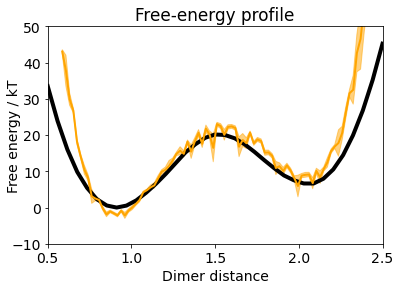

In [33]:
axis = plt.gca()
F_calc_shifted = F_calc - F_calc.min()

axis.plot(us_positions, us_free_energy, color='black', linewidth=4)
axis.plot(bin_values, F_calc, color='orange', linewidth=2)
axis.fill_between(bin_values, F_calc-F_calc_error, F_calc+F_calc_error, color='orange', alpha=0.5)
# axis.errorbar(bin_values, F_calc_shifted, F_calc_error, color='orange', linewidth=2)
axis.set_xlim(0.5, 2.5)
axis.set_ylim(-10, 50)
axis.set_xlabel('Dimer distance')
axis.set_ylabel('Free energy / kT', labelpad=-10)
axis.set_title("Free-energy profile")

Test invertibility
------

In [34]:
# Test invertibility
z = np.random.randn(1000, bg.dim)
x, Jzx = bg.transform_zx_with_jacobian(z)
zrec, Jxz = bg.transform_xz_with_jacobian(x)

# Is invertible?
print(np.abs(z[:,:-6] - zrec[:,:-6]).max())

# Jacobian consistent?
print(np.abs(Jxz + Jzx).max())

5.145526381311605e-05
0.00018310547
